# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *R*

**Names:**

* *Raphael Barman*
* *Thierry Bossy*
* *Raphael Strebel*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [2]:
import networkx as nx
import random as rand
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import csv
%matplotlib inline

In [3]:
# Random walk algorithm
def randomWalk(graph, nb_visits):
    
    nb_nodes = len(graph.nodes())
    
    # Array keeping track of number of times each node is visited (initilized to 0)
    total_visits = [0]*nb_nodes

    # Choose source node randomly
    source = graph.nodes()[rand.randint(0, nb_nodes-1)]
    total_visits[int(source)] = 1 
    current_node = source
    
    for i in range(0, nb_visits-1):
        nb_neighbors = len(graph.neighbors(current_node))
        # Break if we are in an absorbing node
        if(nb_neighbors == 0):
            break
        # Choose next node randomly from the list of neighbors of the current node
        next_node = graph.neighbors(current_node)[rand.randint(0, nb_neighbors-1)]
        # Increment the total number of visits
        total_visits[int(next_node)] = total_visits[int(next_node)] + 1
        current_node = next_node 
    return total_visits

In [4]:
# On components graph
components_graph = nx.DiGraph()
components_graph = nx.read_adjlist('../data/components.graph', create_using=nx.DiGraph())

# Arbitrary number of visits
nb_visits = 10000

print(randomWalk(components_graph, nb_visits))

[0, 0, 0, 0, 2842, 1472, 2843, 2843]


In the components graph, there are two connected components, the first one being (0,1,2,3) and the second one being (4,5,6,7). Since we choose the source randomly, we either start (and stay) in the first component or in the second. When we draw the graph we get:

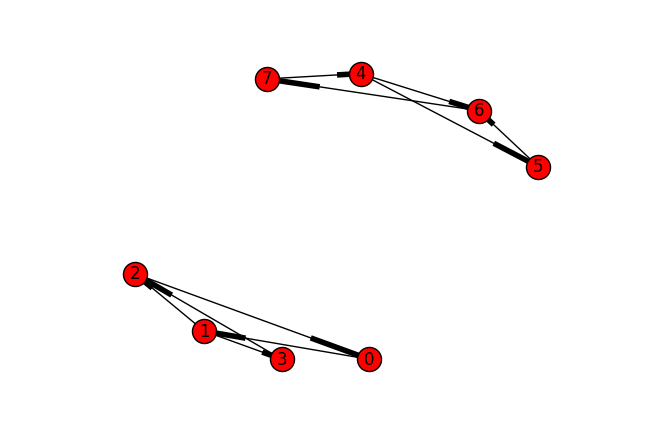

In [5]:
nx.draw(components_graph, with_labels=True)

When we start in the first component, we always go trough the nodes 0, 1 and 2 but we only take the "detour" from node 1 to node 3 with 0.5 probability, before going back to node 2. This explains why nodes 0, 1 and 2 have the same number of visits (+- 1 depending on which is the source) and why node 3 is visited approximately half as much as the other nodes. Similarly, in the second component we pass through nodes 4, 6 and 7 at every turn but we go through node 5 with probability 0.5. So nodes 4, 6 and 7 have the same number of visits (again +-1 depending on the source) and node 5 has approximately half as much visits as the other nodes.

In [6]:
# On absorbing graph 
absorbing_graph = nx.DiGraph()
absorbing_graph = nx.read_adjlist('../data/absorbing.graph', create_using=nx.DiGraph())

# Arbitrary number of visits
nb_visits = 10000

print(randomWalk(absorbing_graph, nb_visits))

[0, 1, 4, 4, 0]


Absorbing graph:
When drawing the absorbing graph we get the following picture:

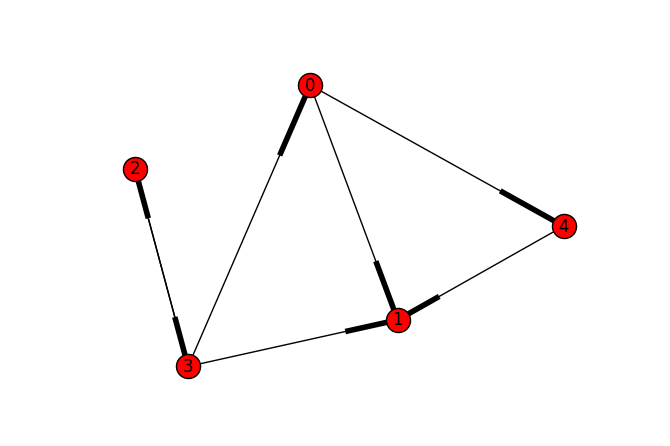

In [7]:
nx.draw(absorbing_graph, with_labels=True)

In the absorbing graph we notice that node 1 is absorbing (it has no outgoing edges), so we stay in node 1 once we arrive at it. The only way we can avoid node 1 is by going back and forth from node 2 to node 3 (one of them has to be the source vertex). However, when in node 3, we go back to node 2 only with probability 1/3, and any other node we travel to ends up going to node 1 : either we go to node 1 directly from node 3, or we go to node 0 which can again either go to node 1 or to node 4. From node 4 we can only go to node 1. This explains why we have so few iterations even when trying to visit a large number of nodes.

#### Exercise 2.13

In [8]:
# Pagerank algorithm
def pageRank(graph, nb_visits):
    nb_nodes = len(graph.nodes())
    
    # Array keeping track of number of times each node is visited (initilized to 0)
    total_visits = [0]*nb_nodes

    # Choose source node randomly
    source = graph.nodes()[rand.randint(0, nb_nodes-1)]
        
    total_visits[int(source)] = 1 
    current_node = source
    
    for i in range(0, nb_visits-1):
        damping_factor = 0.15
        # Choose number randomly between 0 and 1
        r = rand.uniform(0,1)
        # Choose next node randomly with probability 0.15
        if(r <= damping_factor):
            next_node = graph.nodes()[rand.randint(0, nb_nodes-1)]
        else:
            # Choose next node randomly from the list of neighbors of the current node
            nb_neighbors = len(graph.neighbors(current_node))
            # Choose new random node if we are in an absorbing node
            if(nb_neighbors == 0):
                next_node = graph.nodes()[rand.randint(0, nb_nodes-1)]
            else:
                next_node = graph.neighbors(current_node)[rand.randint(0, nb_neighbors-1)]
        total_visits[int(next_node)] = total_visits[int(next_node)] + 1
        current_node = next_node 
    # Compute ratio of visits for all nodes
    ratio = [x / nb_visits for x in total_visits]
    return ratio

In [9]:
# On components graph
components_graph = nx.DiGraph()
components_graph = nx.read_adjlist('../data/components.graph', create_using=nx.DiGraph())

# Arbitrary number of visits
nb_visits = 100000

print(pageRank(components_graph, nb_visits))

[0.1397, 0.13702, 0.14233, 0.07456, 0.1401, 0.07937, 0.14476, 0.14216]


Components graph:
On this graph we see that we visit nodes 0, 1, 2, 4, 6 and 7 with the same probability 1/7 and nodes 3 and 5 are visited with probability 1/14, which makes sense since, as we saw previously, nodes 3 and 5 are visited every second time we go through their respective connected components whereas the other nodes are always visited. The damping factor makes us hop from one connected component to the other with probability 0.15, which showes the resulting total visits of nodes to be consistent.

In [13]:
# On absorbing graph 
absorbing_graph = nx.DiGraph()
absorbing_graph = nx.read_adjlist('../data/absorbing.graph', create_using=nx.DiGraph())

# Arbitrary number of visits
nb_visits = 100000

print(pageRank(absorbing_graph, nb_visits))

[0.149, 0.33919, 0.1468, 0.21322, 0.15179]


Absorbing graph:
We see that we visit node 1 more or less one out of three times, we visit node 3 approximately one out of five times, nodes 0 and 2 are visited with probability ~0.14 and node 4 is visited with probability ~0.15. This result is consistent since all nodes except for one have outgoing edges to node 1. Furthermore, when in node 2, we necessarily go to node 3, which explains why node 3 has more visits than nodes 0, 2 and 4. Node 4 has a bit more visits than nodes 0 and 2 because when in node 4, we go directly to node 1 and then restart from a new random node, which might be node 4 again whereas when in node 0 there is a chance to go to node 4 and when in node 2, we go to node 3, which goes to node 0 with probability 1/3, which in turn can go to node 4. These are just small probabilities but they are visible when the number of visits is high.

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [10]:
def getTransitionMatrix(graph):
    N = nx.number_of_nodes(graph)
    # Compute the transition matrix :
    transition_matrix = np.zeros((N, N), dtype=float)
    for n in graph.nodes():
        out_deg = graph.out_degree(n)
        if(out_deg != 0):
            for s in graph.successors(n):
                transition_matrix[int(n)][int(s)] = 1./float(out_deg)
    return transition_matrix

In [11]:
def getNewTransitionMatrix(graph):
    transition_matrix = getTransitionMatrix(graph)
    N = transition_matrix.shape[0]
    # Select rows with only zeros :
    zeroes = np.where(~transition_matrix.any(axis=1))[0]
    # rows with all zero elements
    w = [0.] * N
    for i in zeroes:
        w[i] = 1.
    ones = np.ones(N,)
    new_transition_matrix = transition_matrix + np.dot(w, ones) * 1 / N
    return new_transition_matrix

In [12]:
def getGoogleMatrix(graph, theta):
    new_transition_matrix = getNewTransitionMatrix(graph)
    N = new_transition_matrix.shape[0]
    google_matrix = theta * new_transition_matrix + (1 - theta) * np.ones((N,N)) * (1. / N)
    return google_matrix

In [13]:
def powerIter(G,init, threshold):
    diff = la.norm(init)
    prev = init
    curr = init
    while(diff > threshold):
        curr = np.dot(prev,G)
        diff = np.abs(la.norm(curr)-la.norm(prev))
        prev = curr
    return curr

In [14]:
def pageRankIter(graph, theta = 0.85, threshold = 0.001):
    N = nx.number_of_nodes(graph)
    G  = getGoogleMatrix(graph,theta)
    init = np.full((N,), 1./N, dtype=float)
    return powerIter(G,init,threshold)

In [15]:
titles = {}
with open('../data/wikipedia_titles.tsv') as file:
    reader = csv.reader(file, delimiter='\t')
    # skip first row
    next(reader,None)
    for row in reader:
        titles[int(row[0])] = row[1]

In [16]:
wiki_graph = nx.DiGraph()
wiki_graph = nx.read_adjlist('../data/wikipedia.graph', create_using=nx.DiGraph())
topPages = pageRankIter(wiki_graph).argsort()[-10:][::-1]
for page in topPages:
    print(titles[page])

United States
United Kingdom
England
France
Europe
Biological classification
Animal
World War II
London
Germany


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*

In [17]:
# On wiki graph
wiki_graph = nx.DiGraph()
wiki_graph = nx.read_adjlist('../data/wikipedia.graph', create_using=nx.DiGraph())
page_rank = pageRankIter(wiki_graph)

# Index of history of mathematics : 2463
history_index= 2463
print("Rank of %s before is %.2E"%(titles[history_index],page_rank[history_index]))
top_300 = page_rank.argsort()[-300:][::-1]
for page in top_300:
    wiki_graph.add_edge(page,history_index)
page_rank = pageRankIter(wiki_graph)
print("Rank of %s before is %.2E"%(titles[history_index],page_rank[history_index]))
print("New top 10")
topPages = pageRankIter(wiki_graph).argsort()[-10:][::-1]
for page in topPages:
    print(titles[page])
# Naive Idea : add edges from 300 pages with highest rank to history of mathematics
# Similar to lab 3 to get indices of 300 highest ranked pages

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


Rank of History of mathematics before is 1.65E+153
Rank of History of mathematics before is 2.08E+156
New top 10
History of mathematics
United States
United Kingdom
England
France
Biological classification
Europe
Animal
London
World War II


In [18]:
wiki_graph = nx.DiGraph()
wiki_graph = nx.read_adjlist('../data/wikipedia.graph', create_using=nx.DiGraph())
pr = nx.pagerank(wiki_graph)
print(pr[str(history_index)])
for page in sorted(pr, key=pr.get,reverse=True)[:300]:
    wiki_graph.add_edge(int(page),history_index)
pr = nx.pagerank(wiki_graph)
print(pr[history_index])
print("New top 10")
topPages = sorted(pr, key=pr.get,reverse=True)[:10]
for page in topPages:
    print(titles[int(page)])

9.705905353496405e-05
0.006838343001831803
New top 10
United States
History of mathematics
United Kingdom
France
Europe
Germany
England
World War II
Latin
India
